In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import torch.utils.data as thdat

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

###
import functools
import seaborn as sns

sns.set_theme()
torch.manual_seed(3407)
np.random.seed(3407)

cpu


In [55]:
def gradient(outputs, inputs):
    return torch.autograd.grad(outputs=outputs,
                               inputs=inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)
#end-def

def coolingPrinciple(T0=100, Tenv=25, r=0.001, time=0):
    return ((T0 - Tenv) * np.exp(-r * time)) + Tenv
#end-def
# time, Tenv, T0, R

def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)
#end-def

In [56]:
coolingPrinciple(time=0.0, r=0.005)

100.0

In [57]:
v= np.array([0, 1, 2, 3, 4, 5])
np_to_th(v)

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.]])

In [6]:
class Net(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=1e-3,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)

        return out

    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)

        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight + self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses

    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()


class NetDiscovery(Net):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=0.001,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__(
            input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight
        )

        self.r = nn.Parameter(data=torch.tensor([0.]))

Text(0.5, 0, 'Time (s)')

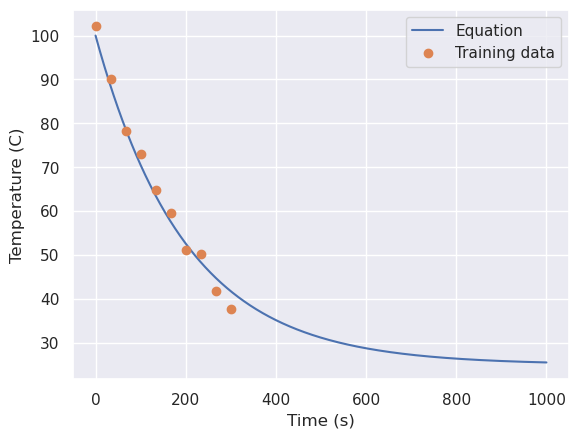

In [40]:
T0 = 100
Tenv = 25
r = 0.005

times = np.linspace(0, 1000, 1000)
temps = coolingPrinciple(T0=T0, Tenv=Tenv, r=r, time=times)

t = np.linspace(0, 300, 10)
T = coolingPrinciple(T0=T0, Tenv=Tenv, r=r, time=t) + (2.0 * np.random.randn(10))

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

Epoch 0/20000, loss: 5112.71
Epoch 2000/20000, loss: 2609.45
Epoch 4000/20000, loss: 2355.93
Epoch 6000/20000, loss: 1168.09
Epoch 8000/20000, loss: 27.10
Epoch 10000/20000, loss: 2.49
Epoch 12000/20000, loss: 2.31
Epoch 14000/20000, loss: 2.20
Epoch 16000/20000, loss: 2.03
Epoch 18000/20000, loss: 1.83
t: [  0.          33.33333333  66.66666667 100.         133.33333333
 166.66666667 200.         233.33333333 266.66666667 300.        ]
t: [102.07808778  90.15820015  78.35370462  72.97265752  64.81804688
  59.65135293  51.18334623  50.22599155  41.8649312   37.71788018]


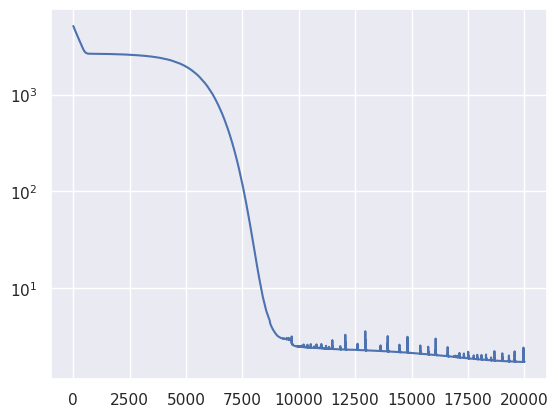

In [43]:
net = Net(1, 1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')

print(f't: {t}')
print(f'T: {T}')

In [58]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))
#end-def

Epoch 0/20000, loss: 10591.99
Epoch 2000/20000, loss: 4031.60
Epoch 4000/20000, loss: 2548.71
Epoch 6000/20000, loss: 1729.23
Epoch 8000/20000, loss: 1333.66
Epoch 10000/20000, loss: 1146.76
Epoch 12000/20000, loss: 1043.29
Epoch 14000/20000, loss: 956.57
Epoch 16000/20000, loss: 880.30
Epoch 18000/20000, loss: 807.89


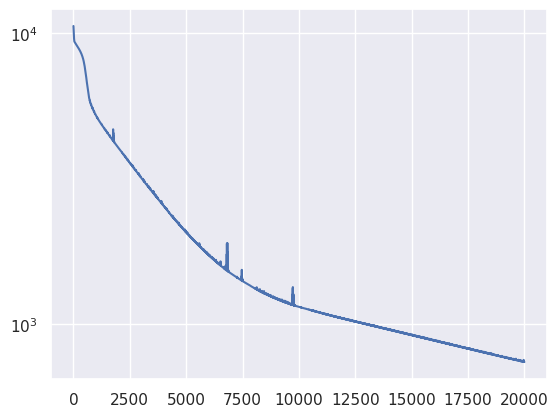

In [59]:
netreg = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses = netreg.fit(t, T)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

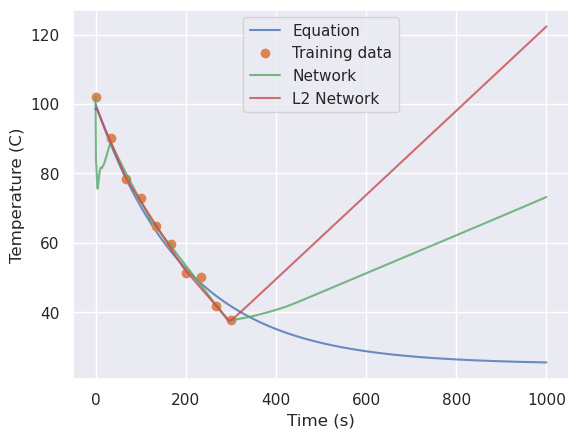

In [60]:
predsreg = netreg.predict(times)

preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network', 'L2 Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

In [61]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = gradient(temps, ts)[0]
    pde = r*(Tenv - temps) - dT
    
    return torch.mean(pde**2)

Epoch 0/30000, loss: 4518.60
Epoch 3000/30000, loss: 2486.06
Epoch 6000/30000, loss: 274.58
Epoch 9000/30000, loss: 2.65
Epoch 12000/30000, loss: 2.32
Epoch 15000/30000, loss: 2.27
Epoch 18000/30000, loss: 2.21
Epoch 21000/30000, loss: 2.16
Epoch 24000/30000, loss: 2.14
Epoch 27000/30000, loss: 2.10


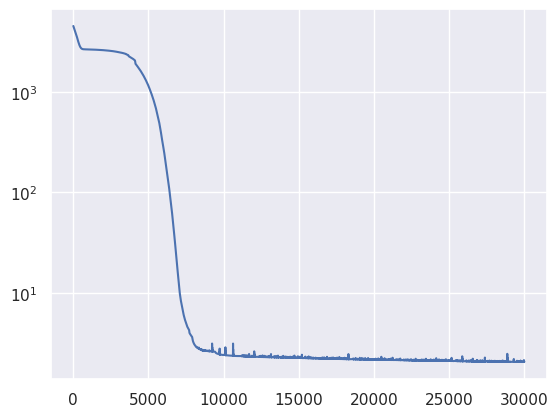

In [62]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

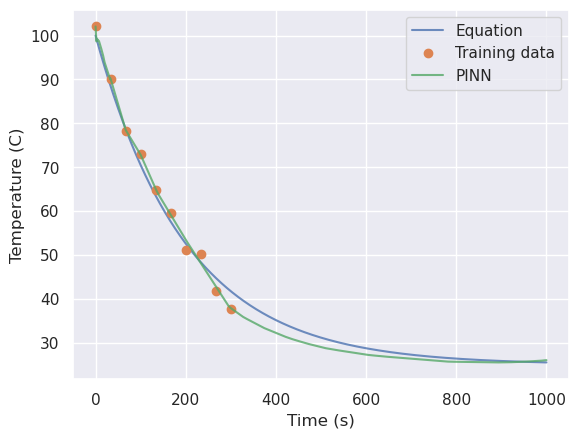

In [63]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

In [66]:
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = gradient(temps, ts)[0]
    pde = model.r * (Tenv - temps) - dT
    
    return torch.mean(pde**2)

Epoch 0/40000, loss: 4884.68
Epoch 4000/40000, loss: 2601.21
Epoch 8000/40000, loss: 2108.42
Epoch 12000/40000, loss: 575.85
Epoch 16000/40000, loss: 11.67
Epoch 20000/40000, loss: 2.43
Epoch 24000/40000, loss: 2.34
Epoch 28000/40000, loss: 2.26
Epoch 32000/40000, loss: 2.23
Epoch 36000/40000, loss: 2.23


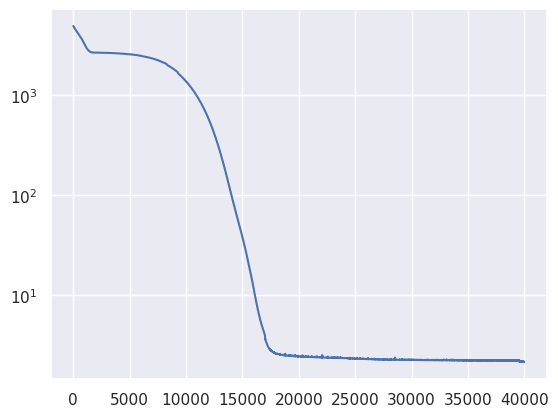

In [67]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)

losses = netdisc.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Parameter containing:
tensor([0.0043], requires_grad=True)


Text(0.5, 0, 'Time (s)')

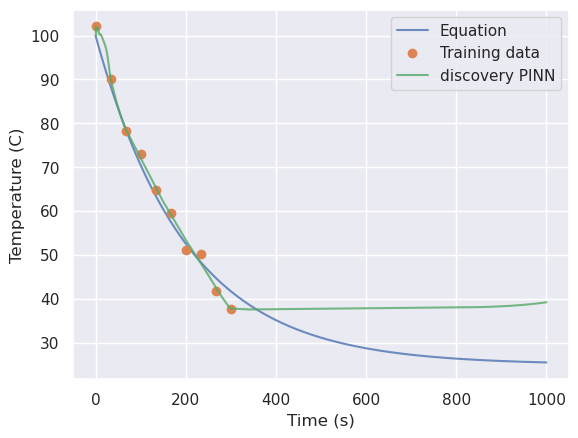

In [68]:
preds = netdisc.predict(times)
print(netdisc.r)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'discovery PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')